<h1>
Classifiers
</h1>

In [1]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

from scipy.stats import chisquare

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Normalization
from tensorflow.keras.utils  import normalize
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

2024-07-02 15:36:43.521119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
TrainingColums = { "kpi"  : ["nTracks","B_P","gamma_PT","Kst_892_0_PT","B_Cone3_B_ptasy","B_ETA"],
                   "pipi" : ["nTracks","B_P","gamma_PT","rho_770_0_PT","B_Cone3_B_ptasy","B_ETA"]}


sharedColums = ["nTracks","B_P","gamma_PT","B_Cone3_B_ptasy", 
                "B_ETA", "B_MINIPCHI2","B_SmallestDeltaChi2OneTrack",
                "B_FD_OWNPV","piminus_PT", "piminus_IP_OWNPV"]


columns    = {"kpi"  : sharedColums + ["Kst_892_0_PT","Kst_892_0_IP_OWNPV","Kplus_PT", "Kplus_IP_OWNPV" ],
              "pipi" : sharedColums + ["rho_770_0_PT","rho_770_0_IP_OWNPV","piplus_PT","piplus_IP_OWNPV"]}


modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"blue" : "#066bd6", "red" : "#d60645",  "pink" : "#2fad66", "green":"#2fad66","black":"#000000"}
path       = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/"
dataframes = {}


In [4]:
#Imports the Sample Data - Target
with uproot.open(path + "data/Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM    = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)
dataframes["kpisw"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" ] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpisw"]["Kplus_IP_OWNPV" ]),list(dataframes["kpisw"]["piminus_IP_OWNPV"])) ]

for var in columns["kpi"]:
    dataframes["kpisw"][f"log({var})"] = np.log10(dataframes["kpisw"][var])


/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
dataframes["pipi"] = pd.read_csv("../data/pipiReweight.csv", index_col=0)
dataframes["kpi" ] = pd.read_csv("../data/kpiReweight.csv",  index_col=0)

dataframes["kpisw"]["isMonteCarlo"] = np.zeros( len(dataframes["kpisw"]) )
dataframes["kpi"  ]["isMonteCarlo"] = np.ones(  len(dataframes["kpi"  ]) )
dataframes["pipi" ]["isMonteCarlo"] = np.ones(  len(dataframes["pipi" ]) )

dataframes["pipi" ] = dataframes["pipi" ][TrainingColums["pipi" ] + ["GBReweight", "isMonteCarlo"]]
dataframes["kpi"  ] = dataframes["kpi"  ][TrainingColums["kpi"  ] + ["GBReweight","isMonteCarlo"]]
dataframes["kpisw"] = dataframes["kpisw"][TrainingColums["kpi"  ] + ["NB0_Kpigamma_sw","isMonteCarlo"]]

dataframes["kpisw"] = dataframes["kpisw"].rename({"NB0_Kpigamma_sw" : "weight",	"Kst_892_0_PT": "daughter_0_PT"},  axis="columns")
dataframes["kpi"  ] = dataframes["kpi"  ].rename({"GBReweight"      : "weight",	"Kst_892_0_PT": "daughter_0_PT"},  axis="columns")
dataframes["pipi" ] = dataframes["pipi" ].rename({"GBReweight"      : "weight",	"rho_770_0_PT": "daughter_0_PT"},  axis="columns")


minLength = min( len(dataframes["kpisw"] ), len(dataframes["kpi"]) )

dataframes["kpisw"] = dataframes["kpisw"].sample(n=minLength)
dataframes["kpi"  ] = dataframes["kpi"  ].sample(n=minLength)

In [6]:
dataframes["kpi"]

,nTracks,B_P,gamma_PT,daughter_0_PT,B_Cone3_B_ptasy,B_ETA,weight,isMonteCarlo
125951,63,174668.296243,10495.000575,3116.978489,0.383340,3.246190,0.531142,1.0
104103,203,149667.408576,3096.039201,3651.363260,-0.265767,4.009145,1.133380,1.0
147889,106,133828.688673,9913.955183,6829.023418,0.334572,2.799140,0.611917,1.0
37261,123,230321.291823,5554.032265,4932.805959,0.314963,3.794181,0.896940,1.0
36768,150,181416.451295,3935.491339,5096.507917,0.316576,3.707676,2.412273,1.0
...,...,...,...,...,...,...,...,...
102727,182,171589.124583,4893.604771,3240.048048,0.130057,3.808226,3.827873,1.0
27613,133,63927.327167,3677.090694,2730.359177,-0.422970,3.331824,0.675174,1.0
98908,69,253961.412525,5975.110293,3812.459192,0.354113,4.102665,0.386740,1.0
194967,168,224005.265146,9661.398834,4679.794687,0.309625,3.466698,1.833934,1.0


In [7]:
dataframes["kpisw"]

,nTracks,B_P,gamma_PT,daughter_0_PT,B_Cone3_B_ptasy,B_ETA,weight,isMonteCarlo
106573,158,86328.824388,10559.553454,2518.912122,0.538680,2.648994,1.289978,0.0
96511,250,63976.261066,3311.785894,2145.496461,-0.683092,3.849283,0.041839,0.0
99510,137,101261.757684,3589.513300,5358.417758,-0.279005,3.307530,-0.397238,0.0
64960,73,136686.029854,4260.959955,5355.915227,0.288504,3.462439,-0.184643,0.0
31431,259,152557.478448,3139.828700,2072.212528,-0.305841,4.070928,1.344838,0.0
...,...,...,...,...,...,...,...,...
143581,59,81906.966412,3430.531732,2491.787326,-0.277096,4.144597,-0.396763,0.0
136253,194,102139.743443,5106.295128,7028.166576,-0.149422,2.881400,1.334428,0.0
105862,138,79279.410773,3640.477406,6308.942952,0.385204,2.890057,0.404395,0.0
102950,121,87830.162760,3535.899319,4069.858879,-0.395443,3.261944,-0.164836,0.0


In [8]:
FullDataTrainingCols = ["nTracks", "B_P", "gamma_PT", "daughter_0_PT", "B_Cone3_B_ptasy", "B_ETA"]

In [9]:
FullData     = pd.concat((dataframes["kpi"],dataframes["kpisw"]))
FullDataNorm = FullData.sample(frac=1)


In [10]:
for var in FullDataTrainingCols:
    FullDataNorm[var] = (FullDataNorm[var] - min(FullDataNorm[var])) / (max(FullDataNorm[var])  -  min(FullDataNorm[var]) )

FullDataNorm

,nTracks,B_P,gamma_PT,daughter_0_PT,B_Cone3_B_ptasy,B_ETA,weight,isMonteCarlo
89125,0.220070,0.107385,0.034137,0.079406,0.430292,0.404626,0.544773,1.0
63162,0.176056,0.040900,0.139277,0.010944,0.400220,0.133957,0.078531,0.0
41002,0.177817,0.088534,0.045537,0.246566,0.821544,0.186985,1.534588,1.0
150652,0.116197,0.079745,0.073161,0.013724,0.692610,0.332974,1.008868,1.0
23471,0.107394,0.069995,0.024658,0.042692,0.394245,0.400064,0.427803,1.0
...,...,...,...,...,...,...,...,...
137185,0.161972,0.140098,0.066616,0.087971,0.666721,0.380045,0.724103,1.0
66028,0.086268,0.099657,0.004226,0.013015,0.416358,0.623413,0.041845,0.0
36994,0.179577,0.029040,0.056745,0.001135,0.641722,0.237638,1.966966,1.0
6470,0.204225,0.105007,0.014859,0.018092,0.554022,0.462129,1.567730,1.0


In [12]:
TrainingData, TestingData = train_test_split(FullDataNorm,test_size=0.1)

X_train = TrainingData[FullDataTrainingCols]
Y_train = TrainingData["isMonteCarlo"]
W_train = TrainingData["weight"]

X_test  = TestingData[FullDataTrainingCols]
Y_test  = TestingData["isMonteCarlo"]
W_test  = TestingData["weight"]


<h1>
Gradient Boosted Decision Tree Classifier
</h1>

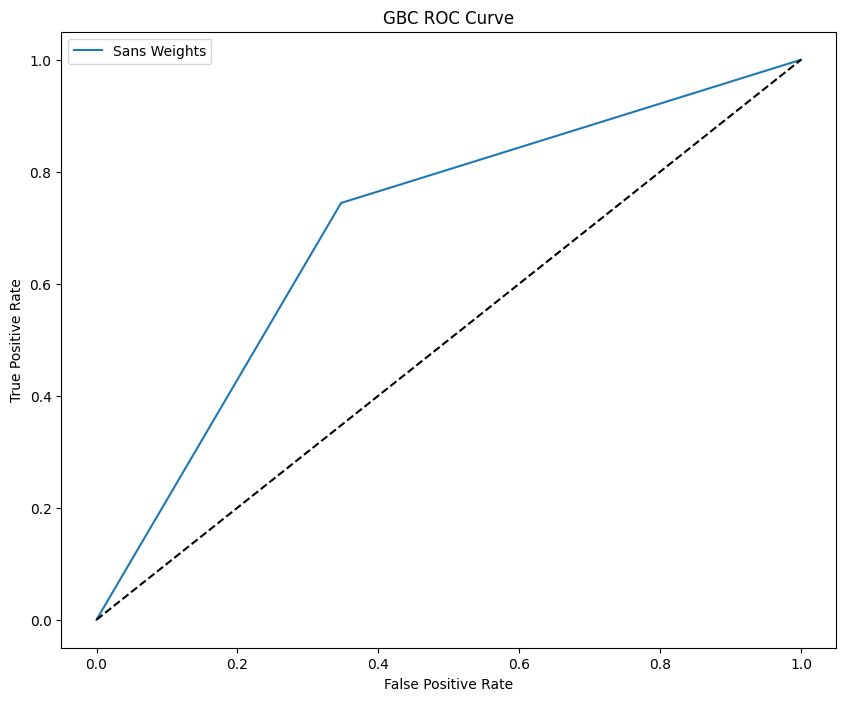

In [27]:
#TODO - Implement ROC curve

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

#TODO - Implement ROC curve

plt.figure(figsize=(10, 8))  # Added for plotting

clf_sw = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(X_train, Y_train)
predictionsWithWeights = clf_sw.predict(X_test).flatten()
fpr, tpr, thresholds   = roc_curve(Y_test, predictionsWithWeights)

plt.plot(fpr,  tpr,  label = "Sans Weights")

plt.plot([0, 1], [0, 1], "k--")  # Added diagonal line for random classifier
plt.xlabel("False Positive Rate")  # Added x-axis label
plt.ylabel("True Positive Rate")  # Added y-axis label
plt.title("GBC ROC Curve")  # Added title
plt.legend()  # Added legend
plt.show()  # Added show plot


<h1>
Neural Networks
</h1>

In [14]:
def CreateNNModel():
    model = Sequential()
    model.add(Dense(12,  input_shape = (6,),  activation="relu"))
    model.add(Dense(12, input_shape = (12,),  activation="relu"))
    model.add(Dense(1,  input_shape = (12,), activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

<h1>
Sans Weights
</h1>

In [15]:
NNmodelSansWeights = CreateNNModel()
NNmodelSansWeights.summary()

/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/HistogramsLHCb/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
predictions = NNmodelSansWeights.predict(X_test).flatten()
cm = confusion_matrix(y_pred=np.round(predictions), y_true=Y_test)
cm

924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[14710,    71],
       [14750,    37]])

In [17]:
EarlyStoppingCallback = EarlyStopping(monitor="val_loss", patience=5)
history = NNmodelSansWeights.fit(X_train, Y_train, validation_data=(X_test, Y_test),  verbose=2, batch_size=200, epochs=500, callbacks=[EarlyStoppingCallback])

Epoch 1/500
1331/1331 - 5s - 4ms/step - accuracy: 0.6559 - loss: 0.6204 - val_accuracy: 0.6882 - val_loss: 0.5935
Epoch 2/500
1331/1331 - 3s - 2ms/step - accuracy: 0.6862 - loss: 0.5889 - val_accuracy: 0.6884 - val_loss: 0.5868
Epoch 3/500
1331/1331 - 3s - 2ms/step - accuracy: 0.6902 - loss: 0.5832 - val_accuracy: 0.6923 - val_loss: 0.5806
Epoch 4/500
1331/1331 - 7s - 5ms/step - accuracy: 0.6940 - loss: 0.5794 - val_accuracy: 0.6952 - val_loss: 0.5794
Epoch 5/500
1331/1331 - 4s - 3ms/step - accuracy: 0.6969 - loss: 0.5772 - val_accuracy: 0.6972 - val_loss: 0.5769
Epoch 6/500
1331/1331 - 3s - 2ms/step - accuracy: 0.6986 - loss: 0.5756 - val_accuracy: 0.6981 - val_loss: 0.5751
Epoch 7/500
1331/1331 - 3s - 2ms/step - accuracy: 0.6990 - loss: 0.5747 - val_accuracy: 0.7002 - val_loss: 0.5748
Epoch 8/500
1331/1331 - 3s - 2ms/step - accuracy: 0.6995 - loss: 0.5738 - val_accuracy: 0.7008 - val_loss: 0.5734
Epoch 9/500
1331/1331 - 2s - 2ms/step - accuracy: 0.7004 - loss: 0.5731 - val_accuracy: 

In [18]:
accuracy = NNmodelSansWeights.evaluate(X_test, Y_test)
print(accuracy)

 32/924 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6976 - loss: 0.5753

924/924 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7061 - loss: 0.5662
[0.5680543184280396, 0.7038013935089111]


In [19]:
predictions = NNmodelSansWeights.predict(X_test).flatten()
cm = confusion_matrix(y_pred=np.round(predictions), y_true=Y_test)
cm

924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[ 9417,  5364],
       [ 3394, 11393]])

<h1>
With Weights
</h1>

In [20]:
NNmodelWithWeights = CreateNNModel()
NNmodelWithWeights.summary()

/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/HistogramsLHCb/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
predictions = NNmodelWithWeights.predict(X_test).flatten()
cm = confusion_matrix(y_pred=np.round(predictions), y_true=Y_test)
cm

924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[14781,     0],
       [14786,     1]])

In [22]:
EarlyStoppingCallback = EarlyStopping(monitor="val_loss", patience=5)
history = NNmodelWithWeights.fit(X_train, Y_train, validation_data=(X_test, Y_test), sample_weight = W_train, verbose=2, batch_size=200, epochs=500, callbacks=[EarlyStoppingCallback])

Epoch 1/500
1331/1331 - 6s - 4ms/step - accuracy: 0.5005 - loss: 0.4045 - val_accuracy: 0.5001 - val_loss: 0.7940
Epoch 2/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5000 - loss: 0.3978 - val_accuracy: 0.5001 - val_loss: 0.8098
Epoch 3/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5004 - loss: 0.3960 - val_accuracy: 0.5007 - val_loss: 0.8124
Epoch 4/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5018 - loss: 0.3954 - val_accuracy: 0.5018 - val_loss: 0.8224
Epoch 5/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5033 - loss: 0.3948 - val_accuracy: 0.5113 - val_loss: 0.7641
Epoch 6/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5057 - loss: 0.3943 - val_accuracy: 0.5048 - val_loss: 0.8156
Epoch 7/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5082 - loss: 0.3938 - val_accuracy: 0.5079 - val_loss: 0.8009
Epoch 8/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5101 - loss: 0.3935 - val_accuracy: 0.5079 - val_loss: 0.8151
Epoch 9/500
1331/1331 - 3s - 2ms/step - accuracy: 0.5129 - loss: 0.3931 - val_accuracy: 

In [23]:
accuracy = NNmodelWithWeights.evaluate(X_test, Y_test)
print(accuracy)

924/924 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5136 - loss: 0.8116
[0.8105741739273071, 0.5139001607894897]


In [24]:
predictions = NNmodelWithWeights.predict(X_test).flatten()
cm = confusion_matrix(y_pred=np.round(predictions), y_true=Y_test)
cm

924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[  413, 14368],
       [    5, 14782]])

924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
924/924 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


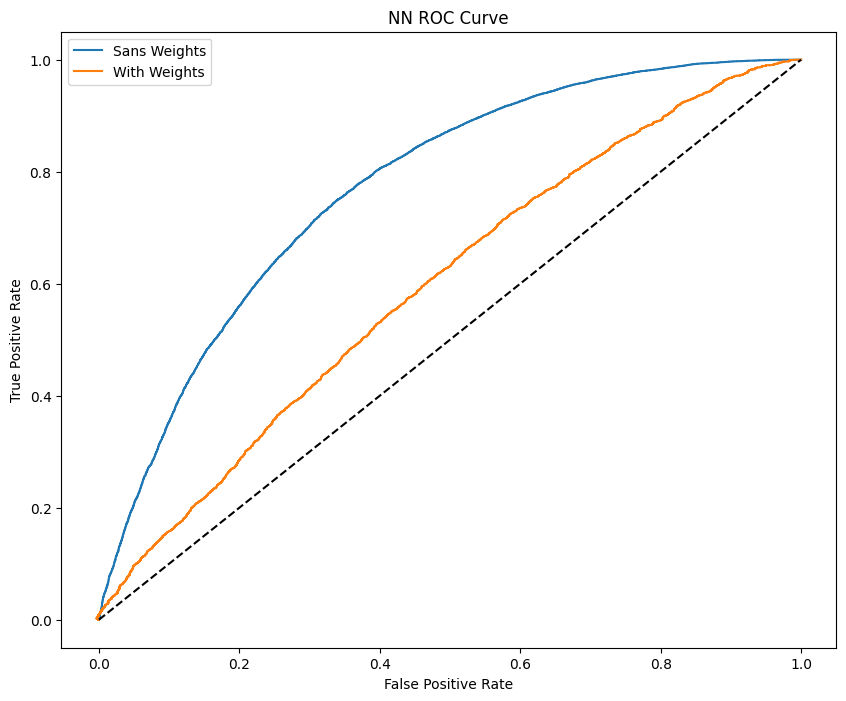

In [25]:
#TODO - Implement ROC curve

plt.figure(figsize=(10, 8))  # Added for plotting

predictionsWithWeights = NNmodelWithWeights.predict(X_test).flatten()
predictionsSansWeights = NNmodelSansWeights.predict(X_test).flatten()


fpr, tpr, thresholds    = roc_curve(Y_test, predictionsSansWeights)
fprw, tprw, thresholdsw = roc_curve(Y_test, predictionsWithWeights, sample_weight=W_test)

plt.plot(fpr,  tpr,  label = "Sans Weights")
plt.plot(fprw, tprw, label = "With Weights")

plt.plot([0, 1], [0, 1], "k--")  # Added diagonal line for random classifier
plt.xlabel("False Positive Rate")  # Added x-axis label
plt.ylabel("True Positive Rate")  # Added y-axis label
plt.title("NN ROC Curve")  # Added title
plt.legend()  # Added legend
plt.show()  # Added show plot